# Classification Project

## Happy Customers

**Background:**

We are one of the fastest growing startups in the logistics and delivery domain. We work with several partners and make on-demand delivery to our customers. From operational standpoint we have been facing several different challenges and everyday we are trying to address these challenges.

We thrive on making our customers happy. As a growing startup, with a global expansion strategy we know that we need to make our customers happy and the only way to do that is to measure how happy each customer is. If we can predict what makes our customers happy or unhappy, we can then take necessary actions.

Getting feedback from customers is not easy either, but we do our best to get constant feedback from our customers. This is a crucial function to improve our operations across all levels.

We recently did a survey to a select customer cohort. You are presented with a subset of this data. We will be using the remaining data as a private test set.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

In [3]:
df = pd.read_csv("C:\\Users\\Azizah\\Downloads\\ACME-HappinessSurvey2020.csv")

In [4]:
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


**Data Description:**

- Y = target attribute (Y) with values indicating 0 (unhappy) and 1 (happy) customers
- X1 = my order was delivered on time
- X2 = contents of my order was as I expected
- X3 = I ordered everything I wanted to order
- X4 = I paid a good price for my order
- X5 = I am satisfied with my courier
- X6 = the app makes ordering easy for me

Attributes X1 to X6 indicate the responses for each question and have values from 1 to 5 where the smaller number indicates less and the higher number indicates more towards the answer.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Y       126 non-null    int64
 1   X1      126 non-null    int64
 2   X2      126 non-null    int64
 3   X3      126 non-null    int64
 4   X4      126 non-null    int64
 5   X5      126 non-null    int64
 6   X6      126 non-null    int64
dtypes: int64(7)
memory usage: 7.0 KB


- There are 7 columns (features) in total, including the target variable **`Y`**.
- There are 126 rows.
- There are no missing values in the dataset.

In [8]:
df.duplicated().sum()

16

There are 16 duplicated rows in the dataset, which is evident even from the first few rows. The output from the head() function shows that the fourth and fifth rows are identical.

Since this dataset is based on a customer feedback survey, it is likely that multiple customers had similar experiences and provided identical responses, leading to these duplicates being flagged.

To determine whether this is purely coincidental or a data entry error, I will analyse all duplicated rows to check for any unusual patterns.

In [10]:
duplicates = df[df.duplicated()]
print(duplicates)

     Y  X1  X2  X3  X4  X5  X6
4    0   5   4   3   3   3   5
22   0   4   3   5   5   5   4
28   1   3   3   1   3   3   4
33   1   3   2   4   4   4   5
37   1   5   3   4   3   4   5
50   1   5   1   3   3   4   4
51   1   5   1   3   3   4   4
53   1   5   2   4   3   4   5
55   1   4   3   2   4   3   4
62   1   5   2   4   4   5   5
65   1   4   1   3   4   4   4
93   1   5   4   4   4   4   5
95   1   5   5   5   5   5   5
107  0   4   2   4   4   4   4
117  1   5   1   5   5   5   5
123  1   5   3   3   4   4   5


The duplicates appear to be purely coincidental, as most responses occur only twice, except for rows 50 and 51, where the same survey answers appear three times. This is still within a reasonable range of expected repetition.

Since these duplicates likely reflect genuine customer feedback rather than data entry errors, I will leave them as they are and make no modifications to the dataset.

In [12]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


Based on the summary statistics above, there appears to be:
- a large gap between the minimum value and the 25th percentile value for **`X1`** and **`X6`** compared to the rest of the percentiles.
- an even spread across the minimum, median and maximum values for **`X2`**.
- an even spread across the minimum, median and maximum values for **`X3`**.
- an even spread across the minimum, median and maximum values for **`X4`**.
- an even spread across the minimum, median and maximum values for **`X5`**.

For some of the features, either the 25th percentile and the median are identical, the median and 75th percentile are the same, or the 75th percentile and maximum value are equal. 
However, this does not pose an issue as the differences between percentile values are not excessively large.

Additionally, all predictor variables (X1 to X6) fall within the expected 1-5 survey scale, and the target variable (Y) is correctly classified as 0 or 1. Standard deviations and interquartile ranges (IQR) show no extreme variability or unexpected values. 
Therefore, I am concluding that there are no outliers and will leave the dataset as it is without any modifications.

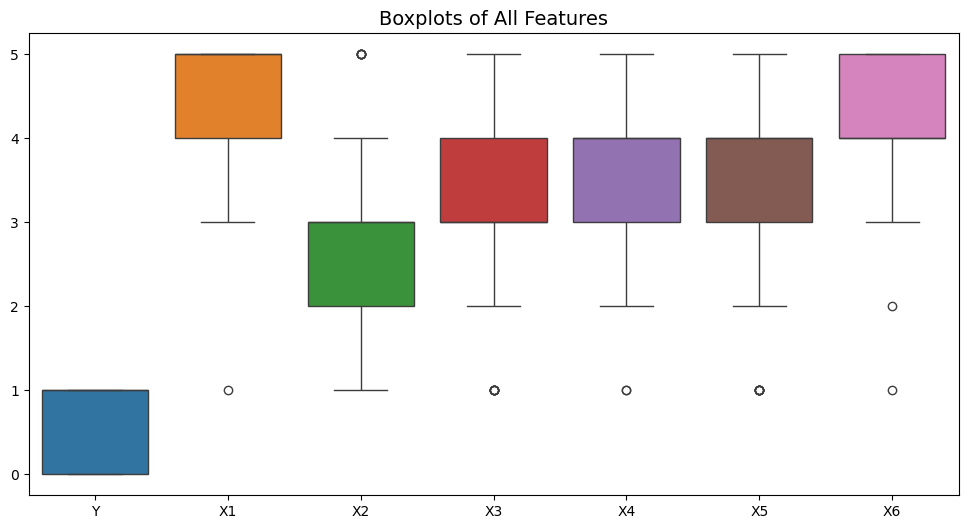

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.title("Boxplots of All Features", fontsize=14)
plt.show()

In [15]:
mean_values = df.mean()
median_values = df.median()
comparison = pd.DataFrame({'Mean': mean_values, 'Median': median_values})
print(comparison)

        Mean  Median
Y   0.547619     1.0
X1  4.333333     5.0
X2  2.531746     3.0
X3  3.309524     3.0
X4  3.746032     4.0
X5  3.650794     4.0
X6  4.253968     4.0


For further confirmation, I have compared the means and medians of each feature. No extreme outliers are apparent, as the mean and median are reasonably close for most variables. Compared to the rest of the features, X1 appears left-skewed, but this just suggests that more responses are clustered towards higher values (closer to 5).

Exploratory data analysis is now complete and I will go on to creating the predictive models. 


### **Model Building**

In [17]:
df['Y'].value_counts(normalize=True)*100

Y
1    54.761905
0    45.238095
Name: proportion, dtype: float64

The dataset has a relatively balanced class distribution, with approximately a 55% to 45% ratio, so resampling is not necessary.

Since logistic regression assumes no multicollinearity among predictor variables, I will generate a correlation heatmap to identify any potential correlations.

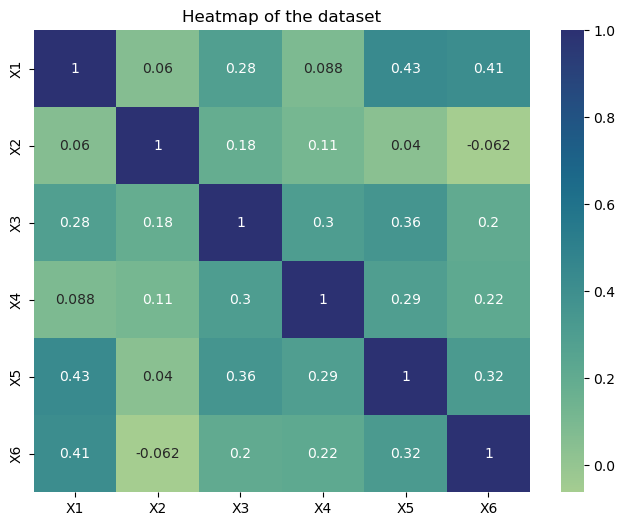

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].corr(), annot=True, cmap = 'crest')
plt.title('Heatmap of the dataset')
plt.show()

All correlations are below 0.5, meaning no two features are highly correlated. Since no variables are highly correlated, each feature likely contributes unique information to predicting customer happiness (Y), hence no need to exclude any feature.

Looking at the descriptions of each feature in the dataset, they all seem to be important features for predicting if the customers are happy or not. However, the **`X3`** feature which represents that a customer ordered everything they wanted to order does not seem to be really important. This is because this depends on the customer’s own decision-making rather than the service provided by the company. Therefore for feature selection, I will be selecting all other features except for the **`X3`** feature.

In [21]:
X = df.copy()
X = X.drop(['X3', 'Y'], axis = 1)
y = df['Y']

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 75, Validation size: 25, Test size: 26


The training set, validation set and test set are approximately 60%, 20%, and 20% at 75, 25, and 26, adding up to the 126 rows size of the dataset.

Since Logistic Regression is a simple model, the target variable is not widely imbalanced, and the dataset is not too complex, I will not be performing hyperparameter tuning on the logistic regression model.

#### Logistic Regression Model

In [24]:
clf = LogisticRegression(random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

clf.fit(X_train, y_train) 

Mean CV Accuracy: 0.5467


LogisticRegression(random_state=42)

#### Decision Tree Model

In [26]:
dt = DecisionTreeClassifier(random_state=42)
tree_para = {'max_depth': [3, 5, 10, None],
             'min_samples_leaf': [1, 5, 10], 
             'min_samples_split': [2, 5, 10],
             'max_features': ['sqrt', 'log2', None],
            }
scoring = ['accuracy', 'precision', 'recall', 'f1']
dt_cv = GridSearchCV(dt, tree_para, scoring=scoring, cv=5, refit = 'accuracy', n_jobs=-1)

In [27]:
%time
dt_cv.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             refit='accuracy',
             scoring=['accuracy', 'precision', 'recall', 'f1'])

In [117]:
path = r"C:\\Users\\Azizah\\OneDrive\\Desktop\\Github Files"
with open(path + '\\dt_cv_model.pickle', 'wb') as to_write: 
    pickle.dump(dt_cv, to_write)

with open(path + '\\dt_cv_model.pickle', 'rb') as to_read:
    dt_cv = pickle.load(to_read)

In [29]:
print(dt_cv.best_score_)
print('')
print(dt_cv.best_params_)

0.6

{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}


In [30]:
dt_best_model = dt_cv.best_estimator_
print(dt_best_model)

DecisionTreeClassifier(max_depth=3, max_features='sqrt', min_samples_split=10,
                       random_state=42)


#### Random Forest Model

In [32]:
rf = RandomForestClassifier(random_state=42)
cv_params = {'max_depth': [3, 5, 10, None],
             'min_samples_leaf': [1, 5, 10], 
             'min_samples_split': [2, 5, 10],
             'max_features': ['sqrt', 'log2', None], 
             'max_samples': [0.5, 0.7, 1.0],
             'n_estimators': [50, 100, 200]}
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit = 'accuracy', n_jobs=-1)

In [33]:
%time
rf_cv.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.5, 0.7, 1.0],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [34]:
path = r"C:\\Users\\Azizah\\OneDrive\\Desktop\\Github Files"
with open(path + '\\rf_cv_model.pickle', 'wb') as to_write: 
    pickle.dump(rf_cv, to_write)

with open(path + '\\rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [35]:
print(rf_cv.best_score_)
print('')
print(rf_cv.best_params_)
print('')
rf_best_model = rf_cv.best_estimator_
print(rf_best_model)

0.64

{'max_depth': 3, 'max_features': None, 'max_samples': 0.7, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}

RandomForestClassifier(max_depth=3, max_features=None, max_samples=0.7,
                       min_samples_leaf=10, random_state=42)


#### XGBoost Model

In [37]:
xgb = XGBClassifier(objective='binary:logistic', random_state=42)
cv_params = {'max_depth': [2, 4, 6],
             'min_child_weight': [3, 5], 
             'learning_rate': [0.01, 0.1],
             'n_estimators': [100, 300]
            }
scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='accuracy', n_jobs=-1)

In [38]:
%time
xgb_cv.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [2, 4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [100, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [39]:
path = r"C:\\Users\\Azizah\\OneDrive\\Desktop\\Github Files"
with open(path + '\\xgb_cv_model.pickle', 'wb') as to_write: 
    pickle.dump(xgb_cv, to_write)

with open(path + '\\xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [40]:
print(xgb_cv.best_score_)
print('')
print(xgb_cv.best_params_)
print('')
xgb_best_model = xgb_cv.best_estimator_
print(xgb_best_model)

0.6266666666666667

{'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 100}

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


### **Model Evaluation**

#### Logistic Regression

In [43]:
log_pred = clf.predict(X_val)

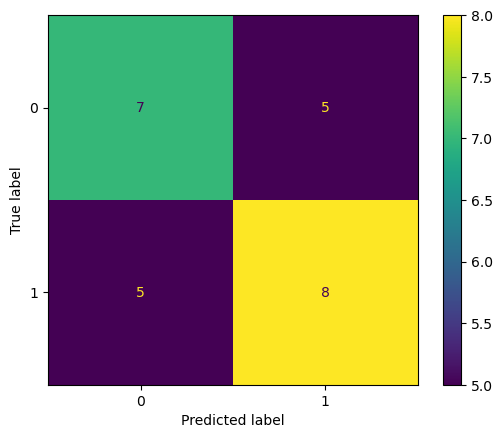

In [44]:
log_cm = metrics.confusion_matrix(y_val, log_pred, labels = clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = log_cm, display_labels = clf.classes_)
disp.plot()

- The model correctly predicted 7 samples as class 0 (negative) when they were actually class 0.
- The model correctly predicted 8 samples as class 1 (positive) when they were actually class 1.
- The model misclassified 5 negative samples as positive.
- The model misclassified 5 positive samples as negative.

In [46]:
train_accuracy = clf.score(X_train, y_train)
val_accuracy = clf.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.6267
Validation Accuracy: 0.6000


The model is not performing well enough on this validation dataset, achieving 62% accuracy instead of the target 73% or more.

Since both accuracies are about the same, without very wide discrepancies, the model is generalising well.

#### Decision Tree

In [49]:
dt_pred = dt_cv.best_estimator_.predict(X_val)

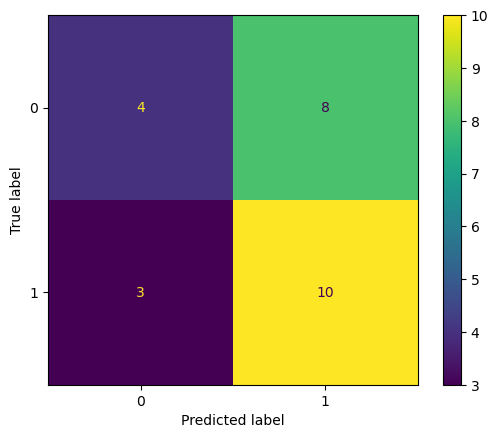

In [50]:
dt_cm = metrics.confusion_matrix(y_val, dt_pred)
dt_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = dt_cm, display_labels = None)
dt_disp.plot()

- The model correctly predicted 4 samples as class 0 (negative) when they were actually class 0.
- The model correctly predicted 10 samples as class 1 (positive) when they were actually class 1.
- The model misclassified 8 negative samples as positive.
- The model misclassified 3 positive samples as negative.

In [125]:
dt_train_accuracy = dt_cv.score(X_train, y_train)
dt_val_accuracy = dt_cv.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.6267
Validation Accuracy: 0.6000


The model is not performing well on this validation dataset, achieving about 63% accuracy, instead of the target 73% or more.

Since both accuracies are about the same, the model is generalising well.

#### Random Forest

In [55]:
rf_pred = rf_cv.best_estimator_.predict(X_val)

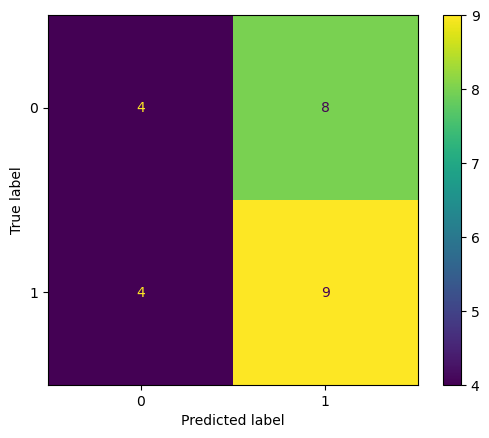

In [56]:
rf_cm = metrics.confusion_matrix(y_val, rf_pred)
rf_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_cm, display_labels = None)
rf_disp.plot()

- The model correctly predicted 4 samples as class 0 (negative) when they were actually class 0.
- The model correctly predicted 9 samples as class 1 (positive) when they were actually class 1.
- The model misclassified 8 negative samples as positive.
- The model misclassified 4 positive samples as negative.

In [58]:
rf_train_accuracy = rf_cv.score(X_train, y_train)
rf_val_accuracy = rf_cv.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.6267
Validation Accuracy: 0.6000


The model is not performing well on this validation dataset, achieving about 63% accuracy, instead of the target 73% or more.

Since both accuracies are about the same, the model is generalising well.

#### XGBoost

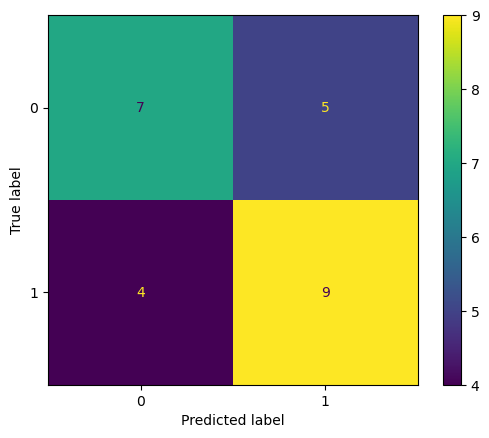

In [61]:
xgb_pred = xgb_cv.best_estimator_.predict(X_val)

xgb_cm = metrics.confusion_matrix(y_val, xgb_pred)
xgb_disp = metrics.ConfusionMatrixDisplay(confusion_matrix = xgb_cm, display_labels=None)
xgb_disp.plot()

- The model correctly predicted 7 samples as class 0 (negative) when they were actually class 0.
- The model correctly predicted 9 samples as class 1 (positive) when they were actually class 1.
- The model misclassified 5 negative samples as positive.
- The model misclassified 4 positive samples as negative.

In [102]:
xgb_train_accuracy = xgb_cv.score(X_train, y_train)
xgb_val_accuracy = xgb_cv.score(X_val, y_val)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Training Accuracy: 0.6267
Validation Accuracy: 0.6000


The model is not performing well on this validation dataset, achieving about 63% accuracy, instead of the target 73% or more.

Since both accuracies are about the same, the model is generalising well.